In [1]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

In [2]:
df = pd.read_parquet('../data/processed/application_clean.parquet')



In [14]:
print(df.columns.tolist())

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMEN

In [3]:
X = df.drop(columns=['TARGET'])
y = df['TARGET'] 

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [5]:
num_cols = X_train.select_dtypes(exclude=['object', 'str']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'str']).columns.tolist()

print("Num cols:", num_cols[:5])
print("Cat cols:", cat_cols[:5])

Num cols: ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']
Cat cols: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE']


In [6]:
from sklearn.impute import SimpleImputer

# Создаем импьютер для числовых признаков
num_imputer = SimpleImputer(strategy='median')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_val[num_cols] = num_imputer.transform(X_val[num_cols])

for col in cat_cols:
    X_train[col] = X_train[col].fillna("missing").astype(str)
    X_val[col] = X_val[col].fillna("missing").astype(str)



In [7]:
model = CatBoostClassifier(
    iterations=900,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
    class_weights=[1,4]
)

model.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_val, y_val))

y_val_pred = model.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.05, 0.5, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_val_pred >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_t))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Применяем лучший порог
y_val_class = (y_val_pred >= best_threshold).astype(int)

roc_auc = roc_auc_score(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_class)
f1 = f1_score(y_val, y_val_class)
recall = recall_score(y_val, y_val_class)
precision = precision_score(y_val, y_val_class)

0:	test: 0.7038465	best: 0.7038465 (0)	total: 381ms	remaining: 5m 42s
100:	test: 0.7517830	best: 0.7517830 (100)	total: 18.3s	remaining: 2m 25s
200:	test: 0.7564190	best: 0.7564492 (199)	total: 35.8s	remaining: 2m 4s
300:	test: 0.7593941	best: 0.7593941 (300)	total: 53.7s	remaining: 1m 46s
400:	test: 0.7609449	best: 0.7609449 (400)	total: 1m 11s	remaining: 1m 29s
500:	test: 0.7619758	best: 0.7619758 (500)	total: 1m 29s	remaining: 1m 11s
600:	test: 0.7622214	best: 0.7622927 (587)	total: 1m 48s	remaining: 53.8s
700:	test: 0.7627130	best: 0.7627150 (693)	total: 2m 6s	remaining: 35.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7628592336
bestIteration = 746

Shrink model to first 747 iterations.


In [13]:
import joblib
import os

os.makedirs('models', exist_ok=True)

joblib.dump(model, 'models/catboost_credit.pkl')


['models/catboost_credit.pkl']

In [8]:
print("ROC-AUC:", roc_auc, "\naccuracy:", accuracy, "\nF1 :", f1, "\nrecall:", recall, "\nprecision:", precision)

ROC-AUC: 0.7628592335673711 
accuracy: 0.8598767539794807 
F1 : 0.31516211061665605 
recall: 0.39939577039274926 
precision: 0.2602703766898543


Лучший порог для F1: 0.42
F1: 0.315
Recall: 0.399
Precision: 0.260


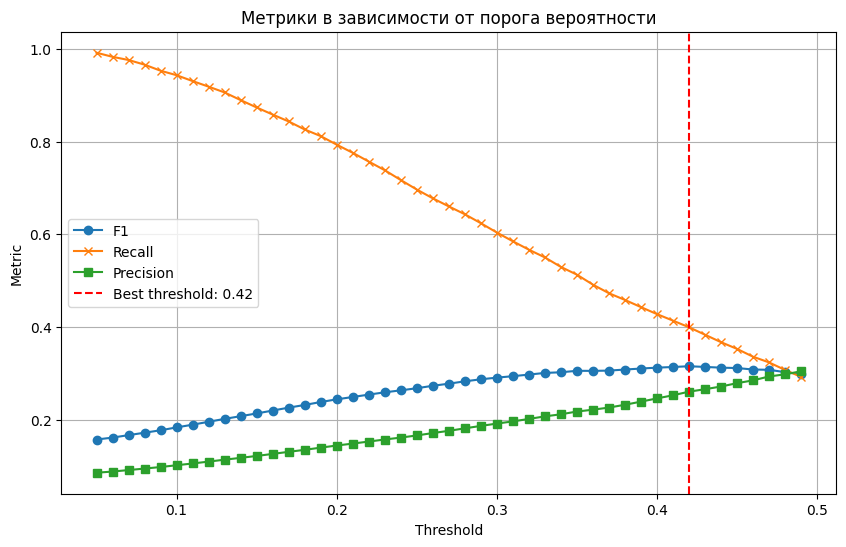

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score

# y_val_pred — вероятности дефолта от CatBoost
# y_val — настоящие метки

# 1️⃣ Диапазон порогов от 0.05 до 0.5 с шагом 0.01
thresholds = np.arange(0.05, 0.5, 0.01)

f1_scores = []
recalls = []
precisions = []

# 2️⃣ Считаем метрики для каждого порога
for t in thresholds:
    y_pred_t = (y_val_pred >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_t))
    recalls.append(recall_score(y_val, y_pred_t))
    precisions.append(precision_score(y_val, y_pred_t))

# 3️⃣ Находим порог с максимальным F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Лучший порог для F1: {best_threshold:.2f}")
print(f"F1: {f1_scores[best_idx]:.3f}")
print(f"Recall: {recalls[best_idx]:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}")

# 4️⃣ Рисуем график
plt.figure(figsize=(10,6))
plt.plot(thresholds, f1_scores, label='F1', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='x')
plt.plot(thresholds, precisions, label='Precision', marker='s')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.title('Метрики в зависимости от порога вероятности')
plt.legend()
plt.grid(True)
plt.show()
